##Mount Drive

In [32]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

my_path = './'


##Imports

In [154]:
import cv2
import numpy as np
import imageio as iio
import random
import pandas as pd
import os
import tensorflow as tf
import keras
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from keras.utils.np_utils import to_categorical
#from google.colab.patches import cv2_imshow

import sys
import numpy
numpy.set_printoptions(threshold=100)

##Pre-processing Data

In [34]:
gestures = ["ASL_letter_A", "ASL_letter_B", "ASL_letter_C",
            "ASL_letter_L", "ASL_letter_R", "ASL_letter_U"]

joints = ["root",
          "thumb_1", "thumb_2", "thumb_3",
          "index_1", "index_2", "index_3", "index_4",
          "middle_1", "middle_2", "middle_3", "middle_4",
          "ring_1", "ring_2", "ring_3", "ring_4",
          "pinky_1", "pinky_2", "pinky_3", "pinky_4"]

ASL_letter_A = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_A/annotations.csv")
ASL_letter_B = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_B/annotations.csv")
ASL_letter_C = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_C/annotations.csv")
ASL_letter_L = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_L/annotations.csv")
ASL_letter_R = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_R/annotations.csv")
ASL_letter_U = pd.read_csv(my_path + "final_project_dataset_v0/ASL_letter_U/annotations.csv") 

ASL_list = [ASL_letter_A, ASL_letter_B, ASL_letter_C,
            ASL_letter_L, ASL_letter_R, ASL_letter_U]

### Generera Train-set och Test set (oslumpad)

In [100]:
def generate_train_set_2(videos_per_gesture=-1, train_size=0.7):
  train_set = []
  test_set = []
  # For each gesture
  for condition in gestures:
    # Get all videos
    v_path = my_path + f"final_project_dataset_v0/{condition}/videos/"
    files = [f for f in os.listdir(v_path) if os.path.isfile(os.path.join(v_path, f))]

    if (videos_per_gesture == -1):
      temp_l = len(files)
      a = round(temp_l * train_size)
      b = temp_l - a
    else:
      a = round(videos_per_gesture * train_size)
      b = videos_per_gesture - a
    train_or_test = "train"
    for f in files:
      f_path = v_path + f
      video_in = iio.get_reader(f_path)
      f_ind = int(f.split('_')[1].split('.')[0])

      if (a > 0):
        train_or_test = "train"
        a -= 1
      elif (b > 0):
        train_or_test = "test"
        b -= 1
      else:
        break

      for i, frame in enumerate(video_in):
        frame_rsz_bw = Image.fromarray(frame).resize((160,120)).convert('L')
        enhancer = ImageEnhance.Contrast(frame_rsz_bw)
        enhanced_frame = np.array(enhancer.enhance(4.0))
        #enhanced_frame = np.array(frame_rsz_bw)

        if (train_or_test == "train"):
          train_set.append({
            "frame_data": enhanced_frame,
            "condition": condition,
            "frame_number": i,
            "video_index": f_ind
          })
        elif (train_or_test == "test"):
          test_set.append({
            "frame_data": enhanced_frame,
            "condition": condition,
            "frame_number": i,
            "video_index": f_ind
          })
  # Return sets        
  #rand_train_set = sorted(train_set, key=lambda k: random.random())
  #rand_test_set = sorted(test_set, key=lambda k: random.random())
  #return np.array(rand_train_set), np.array(rand_test_set)
  return np.array(train_set), np.array(test_set)

train_set, test_set = generate_train_set_2(2)

In [36]:
print(train_set.shape)

(3453,)


## X_train

In [109]:
def get_x_train(x):
    train_set_arr = []
    for pos in x:
        image = pos['frame_data']

        # Rescale the pixel values (between 0 and 255) to the [0, 1] interval: "Neural networks prefer to deal with small input values." 
        image = image.astype('float32')
        image /= 255
        train_set_arr.append(image)
    return np.array(train_set_arr)

x_train = get_x_train(train_set)
x_test = get_x_train(test_set)

##Y_train

###Skapa 160x120-matris med joints definierade

In [38]:
def dist(pointa, pointb, rad): 
  if(getdist(pointa, pointb) < rad):
    return True
  else:
    return False

def getdist(point_a, point_b):
  return round(math.sqrt(abs((point_a[0]-point_b[0])**2+(point_a[1]-point_b[1])**2)))

In [102]:
# We expect an ordered train_set, meaning that
# frames of the same video appear in order
def create_mask(train_set):
    mask_array = np.zeros([120,160])
    all_frames = []
    rad = 5
    old_video_index = -1
    old_ASL_file = -1

    # Timekeeping
    i = 0
    percent = 0
    goalie = len(train_set)

    for pos in train_set:
        i += 1
        if (i >= goalie/20):
            i = 0
            percent += 5
            print(percent, "%")

        frame = pos['frame_number']
        video_index = pos['video_index']
        csv_subset = 0
        ASL_file = ASL_list[gestures.index(pos['condition'])]
        if (video_index != old_video_index or video_index != old_ASL_file):
            csv_subset = ASL_file[ASL_file["video_idx"] == video_index]
    
        frame_csv = csv_subset[csv_subset["frame"] == frame]
        # Go through each joint
        for joint in joints:
            if pos['condition'] in gestures:
            #entry = ASL_file.query(f'frame == "{frame}" & joint == "{joint}" & video_idx == "{video_index}"')
                entry = frame_csv[frame_csv["joint"] == joint]
            if len(entry['joint'].values) > 0:
                x = entry['x'].values[0]
                y = entry['y'].values[0]
                if (x > 0.0) and (y > 0.0):
                    mask_array[int(round(x/4)), int(round(y/4))] = joints.index(entry['joint'].values[0]) + 1
                    for offset_x in range(-2, 3):
                        if int(round(x/4)) + offset_x < 0 or int(round(x/4)) + offset_x >= 120:
                            continue
                        for offset_y in range(-2, 3):
                            if int(round(y/4)) + offset_y  < 0 or int(round(y/4)) + offset_y  >= 160:
                                continue
                            if mask_array[int(round(x/4)) + offset_x, int(round(y/4)) + offset_y] == 0:
                                mask_array[int(round(x/4)) + offset_x, int(round(y/4)) + offset_y] = joints.index(entry['joint'].values[0]) + 1

              #if entry['joint'].values[0] in joints:
              #  for ix in range(160):
              #    for iy in range(120):
              #      if dist([x,y], [ix,iy], rad):
              #        df[iy][ix] = joints.index(entry['joint'].values[0]) + 1
              #  df[int(round(y/4))][int(round(x/4))] = joints.index(entry['joint'].values[0]) + 1
        mask_categorical = to_categorical(y = mask_array, num_classes=21)
        all_frames.append(mask_categorical)
        mask_array = np.zeros([120,160])
    return np.array(all_frames)

y_train = create_mask(train_set)
y_test = create_mask(test_set)

5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %


In [110]:
print(x_test.shape)
print(y_test.shape)

#with np.printoptions(threshold=np.inf):
#    print(y_train[0])

(2350, 120, 160)
(2350, 120, 160, 21)


##Visualizing

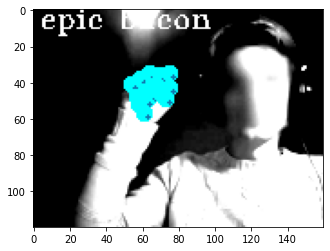

In [104]:
def create_image_overlay(framedata, csv):
  array = np.array(framedata)
  array *= 255
  #HACK!
  temp = Image.fromarray(array)
  temp = temp.convert('RGB')
  temp.save(my_path + "tempimg.png")
  image = iio.imread(my_path + "tempimg.png")

  cv2.putText(image, "epic bacon", (3, 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(255, 255, 255), thickness=1)

  for x in range(160):
    for y in range(120):
      if csv[y, x] != 0:
        cv2.circle(image, (x, y), 2, (0, 255, 255), -1)
        cv2.circle(image, (x, y), 1, (16, 119, 175), -1)

  plt.imshow(image)

create_image_overlay(x_train[1], np.argmax(y_train[1], axis=2))

##Creating model

In [41]:
kernel_size = 3
input_layer = tf.keras.Input(shape=(120,160,1))
n_filters = 1
dropout = 0.1

number_of_classes = 21

conv1 = Conv2D(filters = n_filters * 1, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(input_layer)
conv1 = Conv2D(filters = n_filters * 1, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

conv2 = Conv2D(filters = n_filters * 2, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(pool1)
conv2 = Conv2D(filters = n_filters * 2, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)

conv3 = Conv2D(filters = n_filters * 4, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(pool2)
conv3 = Conv2D(filters = n_filters * 4, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)

# Middle
convm = Conv2D(filters = n_filters * 8, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(pool3)
convm = Conv2D(filters = n_filters * 8, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(convm)

#Decoder
deconv3 = Conv2DTranspose(filters = n_filters * 4, kernel_size = (kernel_size, kernel_size), strides=(2, 2), padding="same")(convm)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(filters = n_filters * 4, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(filters = n_filters * 4, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv3)

deconv2 = Conv2DTranspose(filters = n_filters * 2, kernel_size = (kernel_size, kernel_size), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(filters = n_filters * 2, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(filters = n_filters * 2, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv2)

deconv1 = Conv2DTranspose(filters = n_filters * 1, kernel_size = (kernel_size, kernel_size), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(filters = n_filters * 1, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv1)
uconv1 = Conv2D(filters = n_filters * 1, kernel_size = (kernel_size, kernel_size), activation="relu", padding="same")(uconv1)

output_layer = Conv2D(number_of_classes, (1,1), padding="same", activation="sigmoid")(uconv1)

model = Model(inputs=input_layer, outputs=output_layer, name = "landmark_recognition_model")

##Training model

In [106]:
print(type(np.array(x_train)))
print(type(np.array(y_train)))
print(x_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3453, 120, 160)
(1103, 120, 160, 21)


### Implement weights

In [115]:
import keras.losses 
import keras.backend as K

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx(64)) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]

        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true, tf.cast(pred, tf.int32)) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [141]:
weights = np.array([0.01, 1, 1, 1, 1, 
           1, 1, 1, 1, 1, 
           1, 1, 1, 1, 1, 
           1, 1, 1, 1, 1, 
           1])

weights = weights.astype(np.int32)

model.compile(optimizer='adam', 
              loss = 'categorical_crossentropy',
              #loss=weightedLoss(keras.losses.categorical_crossentropy, weights), 
              metrics=['accuracy',
                        keras.metrics.MeanIoU(num_classes=21),
                        keras.metrics.CategoricalCrossentropy()
                       ]
              )
model.summary()

Model: "landmark_recognition_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 120, 160, 1)  10          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 120, 160, 1)  10          conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 60, 80, 1)    0           conv2d_16[0][0]                  
_________________________________________________________________________

In [137]:
x_train = x_train.astype(np.int32)
y_train = y_train.astype(np.int32)
x_test = x_test.astype(np.int32)
y_test = y_test.astype(np.int32)

print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Epoch 1/2
221/221 [==============================] - 215s 965ms/step - loss: 0.4086 - accuracy: 0.9783 - mean_io_u_7: 0.4762 - categorical_crossentropy: 0.4086 - val_loss: 0.3539 - val_accuracy: 0.9797 - val_mean_io_u_7: 0.4762 - val_categorical_crossentropy: 0.3539
Epoch 2/2
221/221 [==============================] - 215s 974ms/step - loss: 0.3252 - accuracy: 0.9783 - mean_io_u_7: 0.4762 - categorical_crossentropy: 0.3252 - val_loss: 0.2885 - val_accuracy: 0.9797 - val_mean_io_u_7: 0.4762 - val_categorical_crossentropy: 0.2885


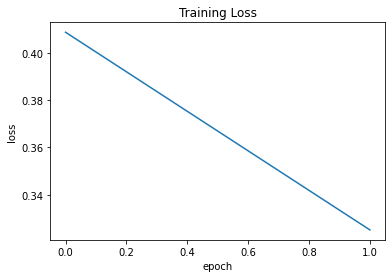

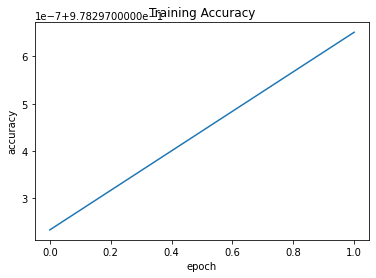

In [142]:
history = model.fit(x_train, y_train, epochs=2, batch_size=5, validation_data=(x_test, y_test))

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

dict_keys(['loss', 'accuracy', 'mean_io_u_1', 'categorical_crossentropy', 'val_loss', 'val_accuracy', 'val_mean_io_u_1', 'val_categorical_crossentropy'])


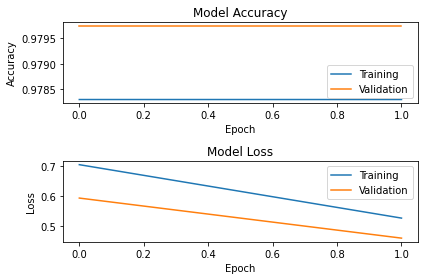

In [112]:
history_dict = history.history
print(history_dict.keys())

plt.figure(1)
# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

#plt.plot(history.history[keras.metrics.MeanIoU(num_classes=21)])
#plt.title("Mean IoU")
#plt.ylabel("MeanIoU")
#plt.xlabel("epoch")
#plt.show()

In [150]:
y_pred1 = model.predict(x_test, verbose=1)

74/74 [==============================] - 14s 187ms/step


In [162]:
#print(y_pred1[0])
print(y_pred1[0].shape)

(160, 21)


In [146]:
#print(y_pred1)
y_pred = np.argmax(y_pred1, axis=3)
#print(y_pred1[0])
#print(y_pred1[0][0].shape)
print(y_pred[0].shape)
print(y_pred[0])

(120, 160)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

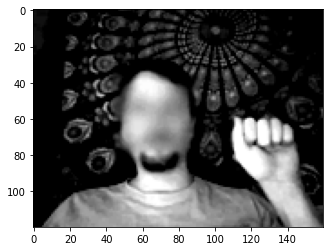

In [84]:
def create_image_overlay2(framedata, csv):
    array = np.array(framedata)
    array *= 255
    #HACK!
    temp = Image.fromarray(array)
    temp = temp.convert('RGB')
    temp.save(my_path + "tempimg.png")
    image = iio.imread(my_path + "tempimg.png")

  #cv2.putText(image, "epic bacon", (3, 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(255, 255, 255), thickness=1)

    for x in range(160):
        for y in range(120):
            if csv[y, x] != 0:
                cv2.circle(image, (x, y), 2, (0, 255, 255), -1)
                cv2.circle(image, (x, y), 1, (16, 119, 175), -1)

    plt.imshow(image)

create_image_overlay2(x_test[0], y_pred[0])

In [ ]:
print(y_pred)



In [ ]:
import csv

with open('y_labels.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write multiple rows
    writer.writerows(y_test)

with open('y_pred.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write multiple rows
    writer.writerows(y_pred)

##Anteckningar till rapporten

Delmoment:
Träna en model som hittar joints givet en inputbild

First we simply train it on the closest pixel given the x, y coordinates.
The accuracy of this is ?????? and one simple way to improve it is to look at a given radius of points around the given coordinates, since a joint is not on an exact point, but has an area. First we must normalize the inputs so that how close a person has their hand to the camera won't affect the training.

One problem with this approach is that if we have too big of a radius, the joints might overlap - to deal with this we try to keep the radii relatively small, and for the overlapping points we tried first of all to take the closest radius, and secondly keep both in a matrix so that both answers would be accepted. The result of the first method was ?????? and the result of the second method was ??????. In the end, a radius of around ?????? gave the best accuracy.